<a href="https://colab.research.google.com/github/KyoungmiKwon/Bigdata_Training_at_ITwill/blob/main/Team_Project/D03_KM_Stock_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install_finance-datareader

In [ ]:
!pip install finance-datareader

# import

In [46]:
import numpy as np
import pandas as pd

import FinanceDataReader as fdr

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 주가 데이터 불러오기

In [47]:
path = '/content/drive/MyDrive/Colab Notebooks/Project/B05_KM_StockPrice_for_regression.xlsx'

#> '122870' : YG      -> KOSDAQ
#> '035900' : JYP     -> KOSDAQ
#> '005930' : 삼성전자
#> '066570' : LG전자


# 주가 데이터 불러오기
stock_ss = pd.read_excel(path,sheet_name = '005930_1', header=0)
stock_lg = pd.read_excel(path,sheet_name = '066570_1', header=0)
stock_yg = pd.read_excel(path,sheet_name = '122870_1', header=0)
stock_jy = pd.read_excel(path,sheet_name = '035900_1', header=0)

# Samsung_005930

## 데이터 불러오기

In [48]:
# 데이터 불러오기

com_code = '005930'   
start_date = '2020-06-01'
end_date = '2021-04-16'

stock_ss = fdr.DataReader(com_code, start=start_date, end=end_date)
stock_ss[:2]

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-06-01,50800,51200,50600,51200,16949183,0.009862
2020-06-02,51000,51500,50800,51400,14247933,0.003906


In [49]:
stock_ss.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

## 데이터 탐색

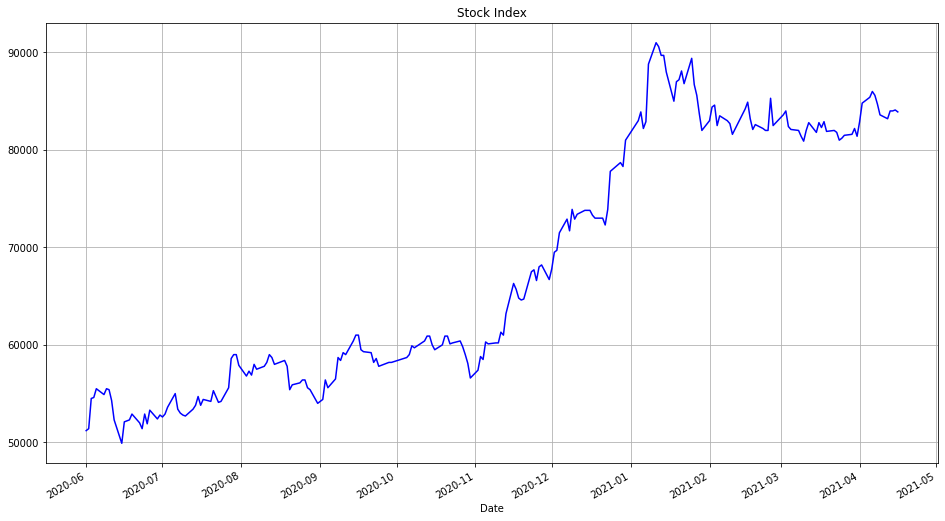

In [50]:
# 삼성 종가 시계열
plt.figure(figsize=(16,9))
stock_ss['Close'].plot(title='Stock Index',color='blue', label='samsung')

plt.grid()
plt.show()

## 데이터전처리_정규화

In [51]:
# 정규화

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0~1 값으로 변환"""
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
    return numerator / (denominator + 0.0000001 )

In [52]:
def CAX_scaling(org_x, x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [53]:
dfx = stock_ss[['Open', 'High', 'Low', 'Close', 'Volume']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

In [54]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2020-06-01 to 2021-04-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    219 non-null    float64
 1   High    219 non-null    float64
 2   Low     219 non-null    float64
 3   Close   219 non-null    float64
 4   Volume  219 non-null    float64
dtypes: float64(5)
memory usage: 10.3 KB


In [55]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2020-06-01 to 2021-04-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   219 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [56]:
x[-1:]

[[0.858227848099093,
  0.7346491228054065,
  0.8510101010079519,
  0.8272506082704932,
  0.0754135896936114]]

In [57]:
y[-2:]

[[0.8321167883191433], [0.8272506082704932]]

In [58]:
# 데이터셋 준비

data_x = []
data_y = []

window_size = 20 # 전날 20일 동안의 모든 데이터를 사용하여 다음날 종가를 예측

for i in range(len(y) - window_size):
    _x = x[i: i+ window_size] # window_size 만큼 종가 예) 1~10일 종가
    _y = y[i+ window_size]    # 11일 종가
    data_x.append(_x)
    data_y.append(_y)

## 세트 분리

In [59]:
# 셋트 분리

tr_size = int(len(data_x)*0.7)

X_tr = np.array(data_x[0:tr_size])
y_tr = np.array(data_y[0:tr_size])

X_ts = np.array(data_x[tr_size:])
y_ts = np.array(data_y[tr_size:])

In [ ]:
X_ts.shape, X_tr.shape

((60, 20, 5), (139, 20, 5))

In [60]:
y_ts.shape, y_tr.shape

((60, 1), (139, 1))

## 모델생성

In [87]:
# 모델 생성하기
md = Sequential()
md.add(LSTM(units= 16, activation='relu', return_sequences=False, input_shape=(window_size,5)))
# md.add(Dropout(1))
# md.add(LSTM(units=10, activation='relu'))
# md.add(Dropout(0.1))
md.add(Dense(units=1))
md.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 16)                1408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


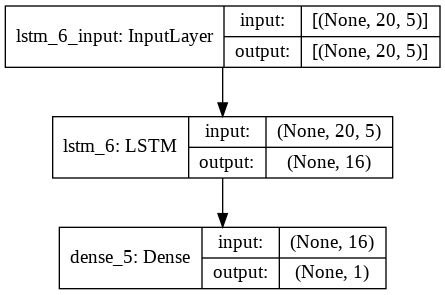

In [88]:
keras.utils.plot_model(md, show_shapes=True)

In [89]:
# 모델컴파일
md.compile(optimizer='adam', loss='mean_squared_error') #> 손실 함수는 평균 제곱오차(MSE)를 사용

In [90]:
# 콜백(조기 종료, 상태 저장)
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint('stock_model.h5', save_best_only=True)

## 모델훈련

In [ ]:
# 훈련
history = md.fit(X_tr,y_tr,batch_size=3, epochs=100, #> batch_size ; 한번에 제공되는 훈련 데이터 갯수 
                #  validation_data=(X_ts,y_ts),    
                # callbacks=[early_stop,check_point]
                 )

In [93]:
y_prd = md.predict(X_ts)

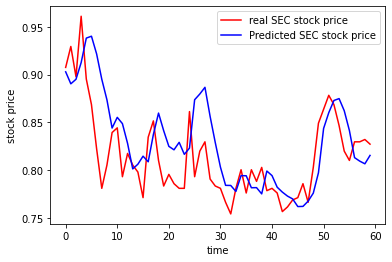

In [94]:
plt.figure()
plt.plot(y_ts, color='red', label='real SEC stock price')
plt.plot(y_prd, color='blue', label='Predicted SEC stock price')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [101]:
# 다음날 예측 종가
a = int(stock_ss['Close'][-1]*y_prd[-1]/dfy['Close'][-1])
# 실제 종가
b = fdr.DataReader('005930', start='2021-04-17', end='2021-04-20')
c = b['Close'][1]

In [102]:
# 결과 출력
print('predict:', a)
print('actual:', c)
print('variance:', a-c)

predict: 82705
actual: 83900
variance: -1195
